### Introduction

The task is to predict whether a BlaBlaCar driver will have at least 1 passenger on board during their trip from one location to another.

According to the problem statement, a driver publishes trips. One publication can lead to one or two trips in case of a round trip. Each trip is composed of several segments, depending on the number of stopovers.

If a driver is travelling from Paris to Toulouse with a stopover in Tours and a stopover in Limoge, there will be 6 segments:

* Paris>Tours (direct)
* Tours>Limoge (direct)
* Limoge>Toulouse (direct)
* Paris>Limoge (indirect)
* Paris>Toulouse (indirect)
* Tours>Toulouse (indirect)

A segment is either a direct trip between two locations or an indirect trip composed of constinuent segments. I suspect that whether a segment is direct or indirect would be a good predictor of success. The number of constituent segments will likely also play a role, as well as the duration and speed.

The segments of a trip form the edges of a DAG (directed acyclic graph). The order of the locations visited is the topological order of the nodes in the graph. Below is an implementation of topological sort for a DAG.

### What this notebook is about

In this notebook I

* Explore the dataset
* Extract useful features
* Create a simple 80-20 train - validation set
* Train XGBClassifier to predict success
* Analyze feature importance as reported by XGBClassifier
* Analyze feature importance using SHAP

In [1]:
import numpy as np
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
import shap

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
from collections import defaultdict
from datetime import datetime
from collections import defaultdict
from itertools import tee
from time import perf_counter

### Loading the dataset

Note that this doesn't load the original CSV file provided, but loads the CSV file that includes features computed using location graphs (stopover count, speed, and duration). These features are computed in notebook `Computing Graph Features.ipynb`

In [2]:
df = pd.read_csv(
    "../data/with_segment_features.csv",
    parse_dates=[
        "segment_datetime",
        "published_date",
        "signup_date"
    ],
    converters={"to": eval, "from": eval}
)

df = df.set_index(["trip_id", "segment_id"])

### Defining the target variable

According to the problem statement, what we're trying to predict is whether there is at least 1 passenger accompanying the driver on a given segment.

We can think about this in two ways:
1. For a particular segment of a given trip, will someone book the car for that segment? (`confirmed_seat_count > 0`)
2. For a particular segment of a given trip, will there be at least one passenger in the car? (`seat_offered_count` > `seat_left_count`)

Note that these two things are different. A passenger may be in the car during a given segment even if they hadn't booked that particular segment: imagine someone going from Paris to Marseille and the trip goes through Lyon. This person will be in the car in the segment Paris -> Lyon and the segment Lyon -> Marseille. This should be counted as a success for segments Paris -> Lyon and Lyon -> Marseille even if no one has booked these segments (`confirmed_seat_count == 0`)

Therefore option 2 makes more sense.

In [3]:
df["target"] = (df["seat_offered_count"] > df["seat_left_count"]).astype(int)

In [4]:
df["target"].value_counts()

1    1693951
0    1685827
Name: target, dtype: int64

<AxesSubplot:>

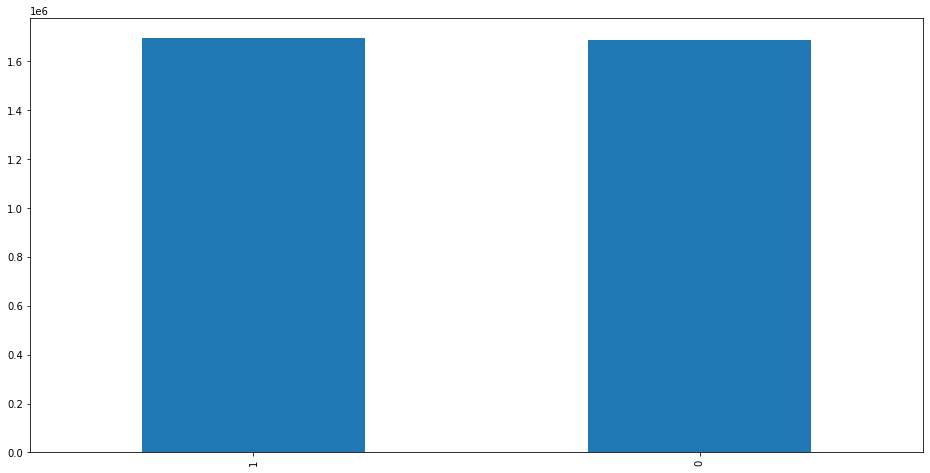

In [5]:
df["target"].value_counts().plot.bar(figsize=(16, 8))

The target variable seems imbalanced. Most likely the examples in the dataset were deliberately chosen to be balanced.

### Effect of driver's signup country

Plot the number of times a driver succeeds to get at least 1 passenger by signup country. Log transformed for better visualization.

<AxesSubplot:xlabel='fixed_signup_country'>

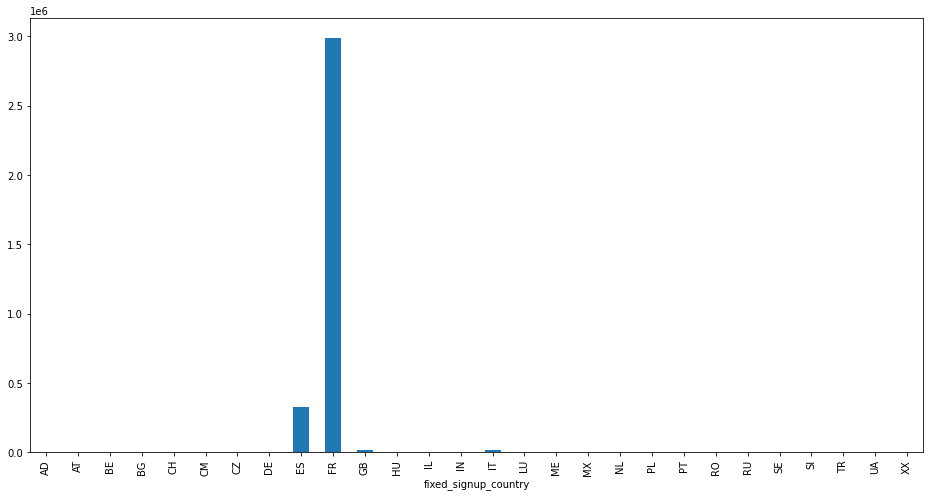

In [6]:
df.groupby("fixed_signup_country").count()["driver_id"].plot.bar(figsize=(16, 8))

<AxesSubplot:title={'center':'Success by Signup Country'}, xlabel='fixed_signup_country'>

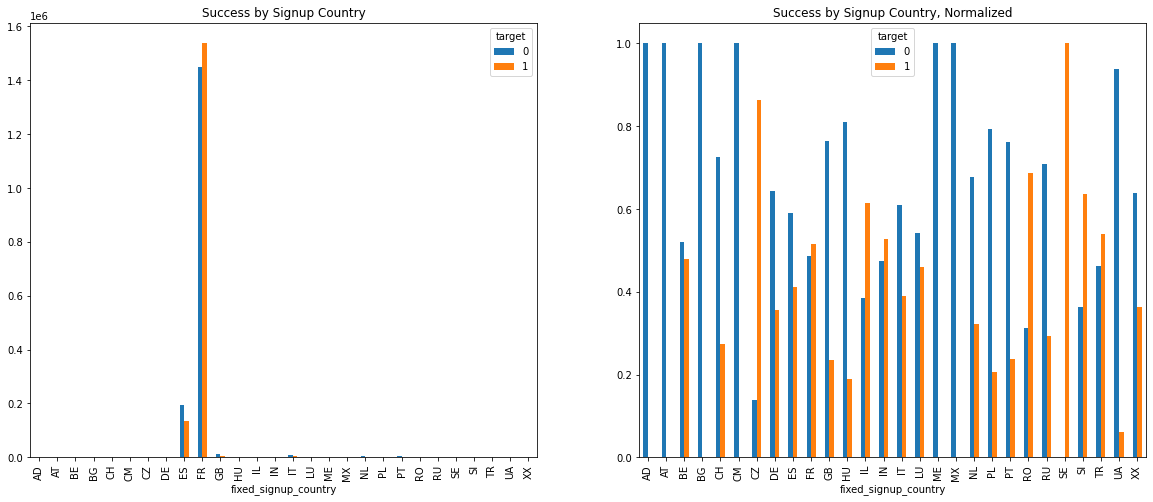

In [7]:
counts = df.groupby(["fixed_signup_country", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

percentages.unstack().plot.bar(title="Success by Signup Country, Normalized", ax=ax[1])
counts.unstack().plot.bar(title="Success by Signup Country", ax=ax[0])

The most represented countries in the dataset are by far France and Spain, followed by Great Britain and Italy.

France seems to have a higher success rate compared to Spain, Great Britain and Italy.

In some countries, drivers either always fail (AD) or always succeed (SE) in matching with passengers, but this is to be taken with a grain of salt because the number of segments to support such a hypothesis is insignificant.

### Effect of publication site

`publication_site_id` is the ID of the site used by the driver to create the publication.

<AxesSubplot:xlabel='publication_site_id'>

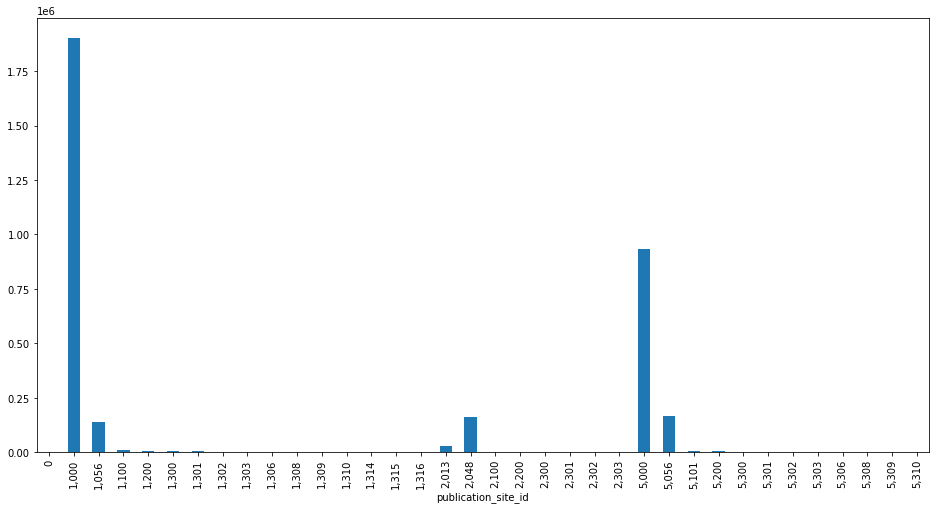

In [8]:
df.groupby("publication_site_id").count()["driver_id"].plot.bar(figsize=(16, 8))

<AxesSubplot:title={'center':'Success by Site ID'}, xlabel='publication_site_id'>

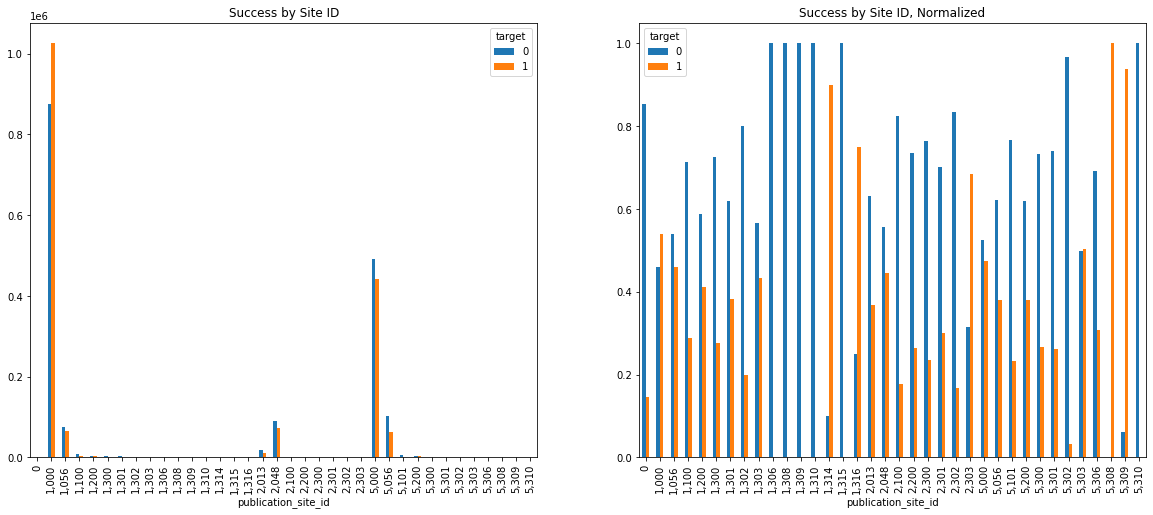

In [9]:
counts = df.groupby(["publication_site_id", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

percentages.unstack().plot.bar(title="Success by Site ID, Normalized", ax=ax[1])
counts.unstack().plot.bar(title="Success by Site ID", ax=ax[0])

Drivers using site "1,000" are more likely to match with passengers.

### Datetime features

* How many days (fractional) was the publication made before the trip
* Driver experience (number of months (fractional) since driver account was created)
* Day of week
* Month of year
* Pickup hour

In [10]:
df["days_before_start"] = (df["segment_datetime"] - df["published_date"]).apply(
    lambda x: x.total_seconds()/(3600 * 24)
)
df["months_since_signup"] = (df["published_date"] - df["signup_date"]).apply(
    lambda x: x.total_seconds()/(3600 * 24 * 30)
)

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["pickup_weekday"] = df["segment_datetime"].dt.weekday.apply(lambda x: weekdays[x])

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
df["pickup_month"] = df["segment_datetime"].dt.month.apply(lambda x: months[x - 1])
df["pickup_hour"] = df["segment_datetime"].dt.hour

### Effect of pickup weekday

(-1.0, 7.0)

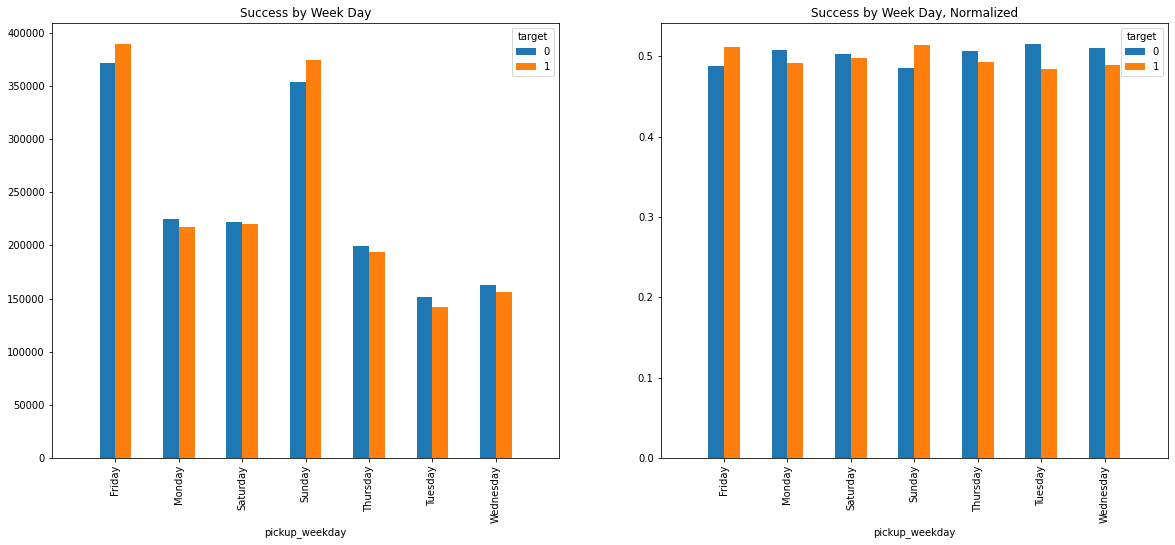

In [12]:
df_temp = df[["pickup_weekday", "target", "driver_id"]].copy()
df_temp["pickup_weekday"] = df_temp["pickup_weekday"]

counts = df_temp.groupby(["pickup_weekday", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Week Day", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Week Day, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 7))
ax[1].set_xlim((-1, 7))

### Effect of pickup month

(-1.0, 7.0)

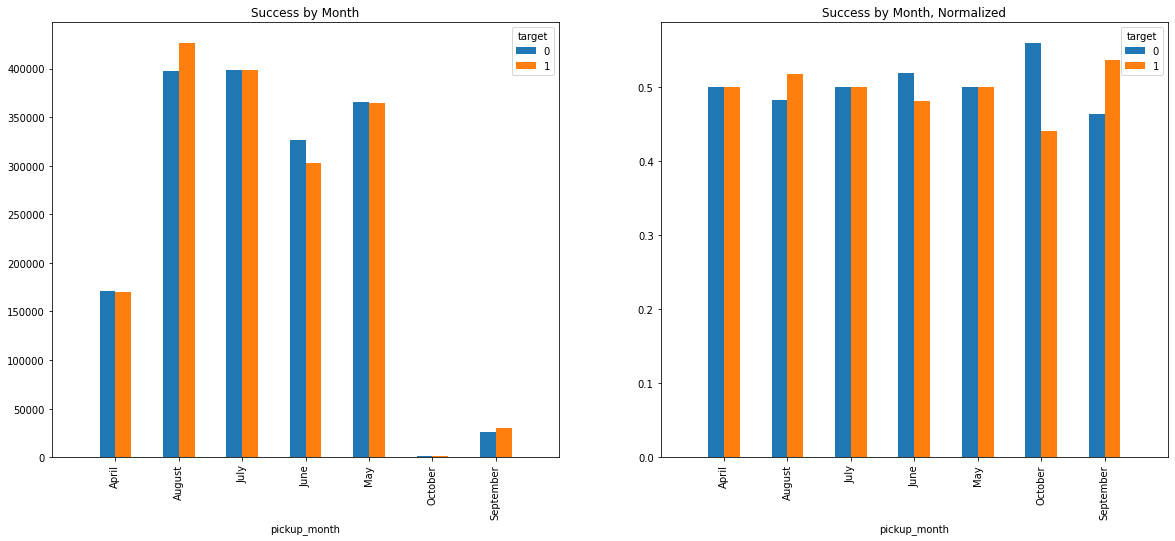

In [13]:
df_temp = df[["pickup_month", "target", "driver_id"]].copy()
df_temp["pickup_month"] = df_temp["pickup_month"]

counts = df_temp.groupby(["pickup_month", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Month", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Month, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 7))
ax[1].set_xlim((-1, 7))

### Categorical features

Encode as one hot features
* fixed_signup_country
* publication_site_id

In [11]:
one_hot = pd.get_dummies(df["fixed_signup_country"])
df.drop("fixed_signup_country", axis=1, inplace=True)
df = df.join(one_hot)

one_hot = pd.get_dummies(df["publication_site_id"])
df.drop("publication_site_id", axis=1, inplace=True)
df = df.join(one_hot)

one_hot = pd.get_dummies(df["pickup_weekday"])
df.drop("pickup_weekday", axis=1, inplace=True)
df = df.join(one_hot)

one_hot = pd.get_dummies(df["pickup_month"])
df.drop("pickup_month", axis=1, inplace=True)
df = df.join(one_hot)

### Effect of the number of days a publication is made before the trip

(-1.0, 50.0)

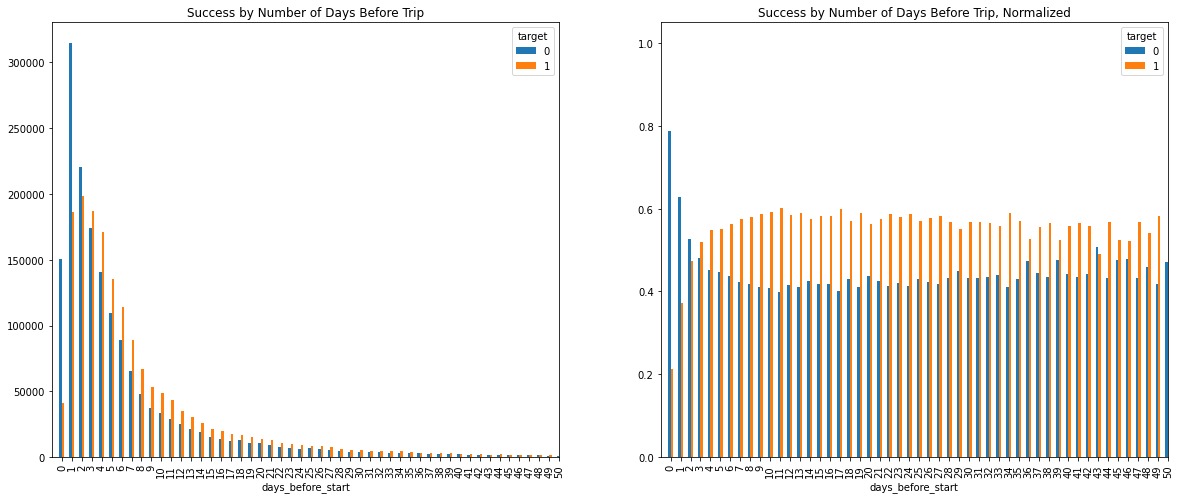

In [13]:
df_temp = df[["days_before_start", "target", "driver_id"]].copy()
df_temp["days_before_start"] = df_temp["days_before_start"].astype(int)

counts = df_temp.groupby(["days_before_start", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Number of Days Before Trip", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Number of Days Before Trip, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 50))
ax[1].set_xlim((-1, 50))

It seems clear that if the driver makes their publication more than 3 days in before the trip they're more likely to succeed.

### Effect of driver experience

(-1.0, 48.0)

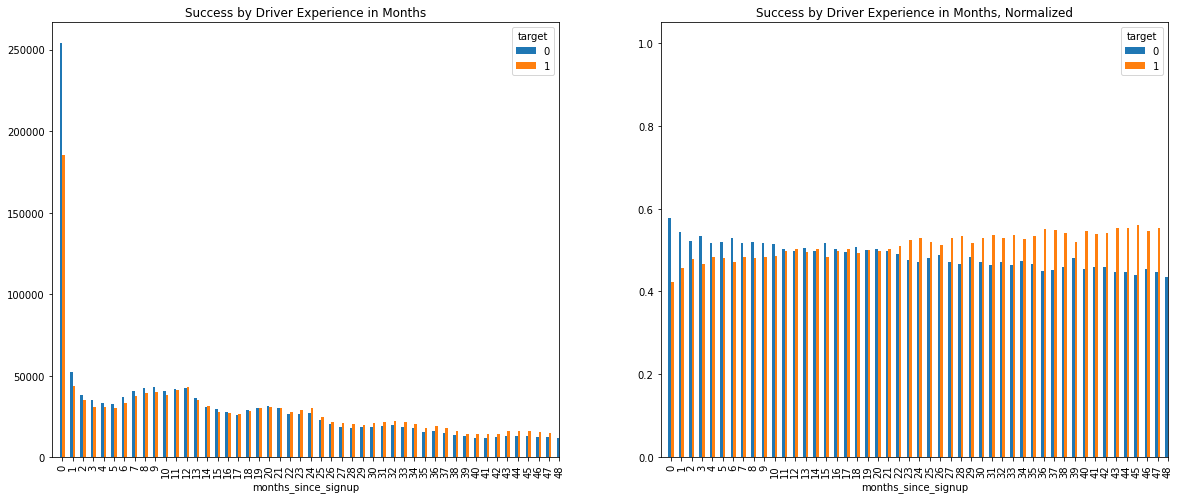

In [15]:
df_temp = df[["months_since_signup", "target", "driver_id"]].copy()
df_temp["months_since_signup"] = df_temp["months_since_signup"].astype(int)

counts = df_temp.groupby(["months_since_signup", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Driver Experience in Months", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Driver Experience in Months, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 48))
ax[1].set_xlim((-1, 48))

Drivers with more than 21 months of experience seem more likely to succeed. Likely because they have a high number of ratings on the platform.

Success rate is slightly higher on Fridays and Sundays, which makes sense. People are either going somewhere for to spend the weekend or coming back home before the work week starts.

No clear conclusions here. It doesn't seem that success rate is affected much by pickup month.

### Effect of pickup hour

(-1.0, 24.0)

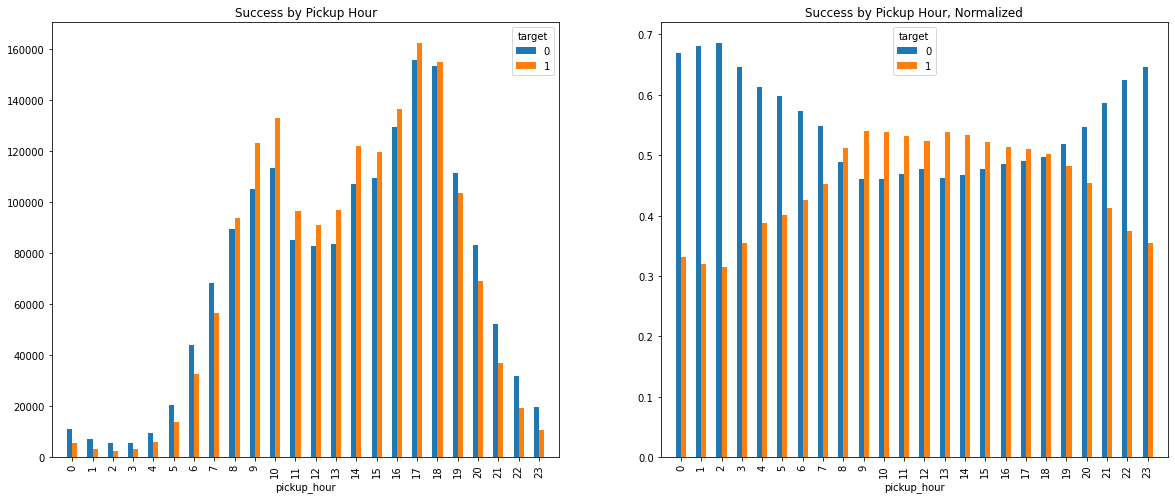

In [21]:
df_temp = df[["pickup_hour", "target", "driver_id"]].copy()

counts = df_temp.groupby(["pickup_hour", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Pickup Hour", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Pickup Hour, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 24))
ax[1].set_xlim((-1, 24))

Success is more likely during the day as opposed to late at night or very early in the morning.

### Effect of the number of stopovers

(-1.0, 11.0)

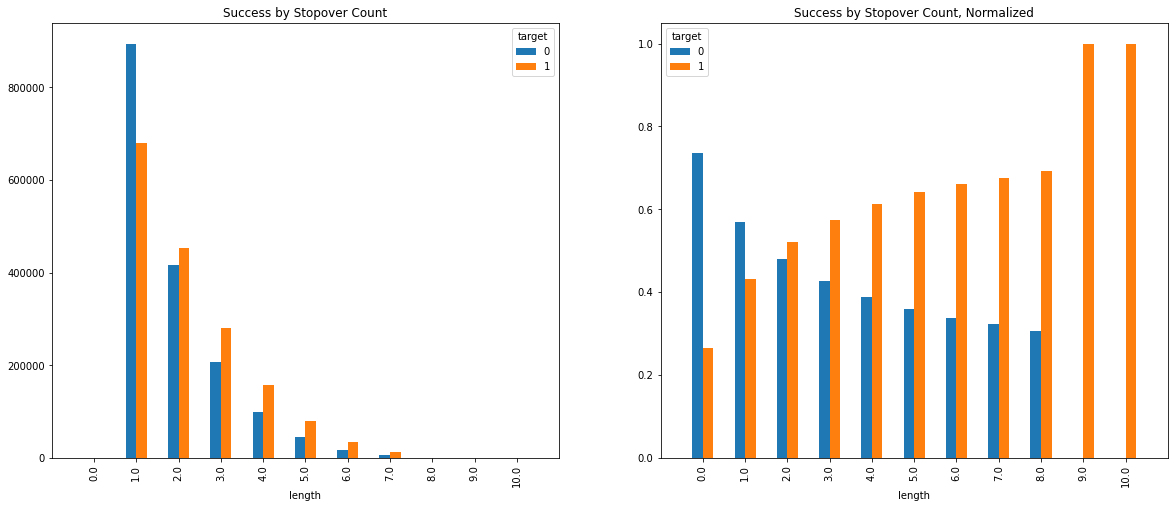

In [22]:
df_temp = df[["length", "target", "driver_id"]].copy()

counts = df_temp.groupby(["length", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Stopover Count", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Stopover Count, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 11))
ax[1].set_xlim((-1, 11))

This one is interesting. The higher the number of stopovers the more likely the driver is to succeed. This is probably because having a larger number of stopovers attracts people interested in going from stopovers to stopovers.

### Effect of speed

(-1.0, 18.0)

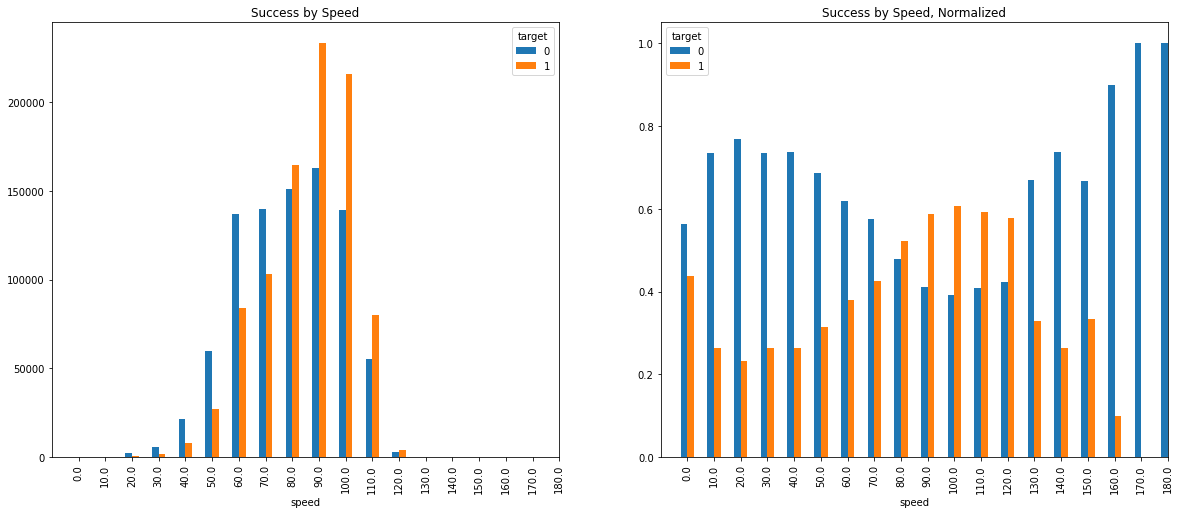

In [23]:
df_temp = df[["speed", "target", "driver_id", "FR", "ES"]].copy()
df_temp["speed"] = df_temp["speed"].apply(lambda x: round(x, -1))

counts = df_temp.groupby(["speed", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Speed", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Speed, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 18))
ax[1].set_xlim((-1, 18))

This one is very interesting: slow speeds are not attractive. A slow speed likely indicates that there is a large amount of rest time between different segments of the trip. Speeds that are too high are not attractive either. It's interesting to see that speeds around 80 -> 120 are the most attractive. This is close to the range of speed limits on French roads. Let's see if there's a difference in speed preferences between France and Spain.

(-1.0, 18.0)

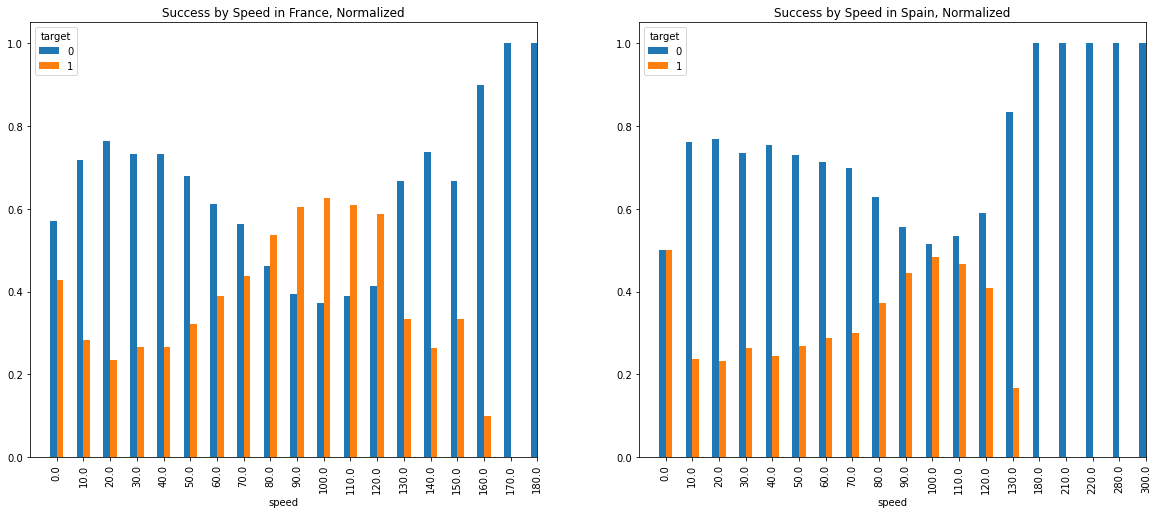

In [24]:
df_temp_fr = df_temp[df_temp["FR"] == 1]
df_temp_es = df_temp[df_temp["ES"] == 1]

counts_fr = df_temp_fr.groupby(["speed", "target"]).count()["driver_id"]
percentages_fr = counts_fr / counts_fr.groupby(level=0).sum()

counts_es = df_temp_es.groupby(["speed", "target"]).count()["driver_id"]
percentages_es = counts_es / counts_es.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

percentages_fr.unstack().plot.bar(title="Success by Speed in France, Normalized", ax=ax[0])
percentages_es.unstack().plot.bar(title="Success by Speed in Spain, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 18))
ax[1].set_xlim((-1, 18))

The pattern seems pretty similar. Although speed in France seems more predictive of success. Also, people in France seem much more tolerant to high speeds (130->160)

### Effect of duration

(-1.0, 18.0)

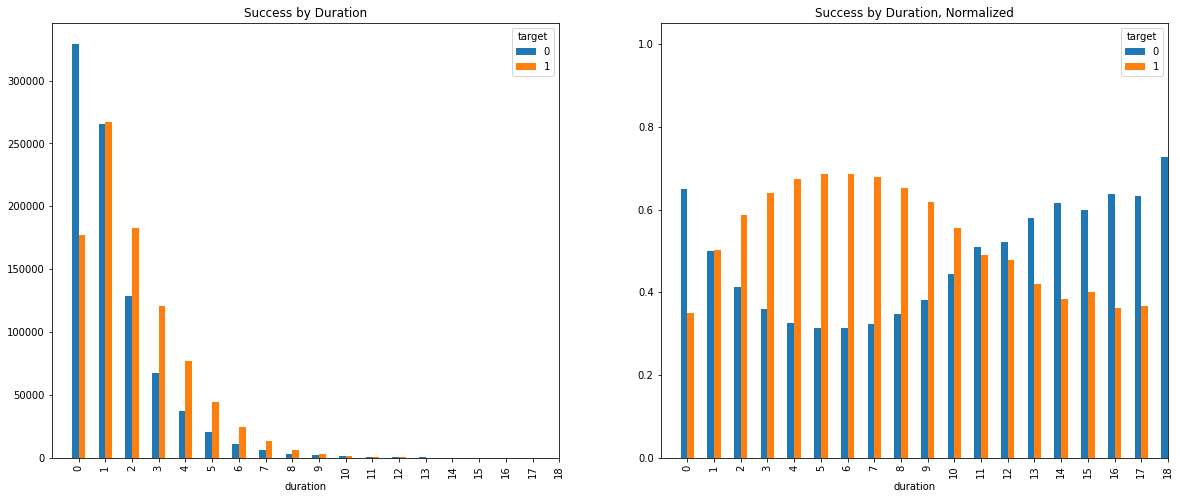

In [25]:
df_temp = df[["duration", "target", "driver_id"]].copy().dropna()
df_temp["duration"] = df_temp["duration"].astype(int)

counts = df_temp.groupby(["duration", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Duration", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Duration, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 18))
ax[1].set_xlim((-1, 18))

Success rate increases with the duration of the trip up to 6 hours, then starts falling. People don't want to spend too much time traveling in a car I guess.

### Clustering locations

I suspect that the pickup and dropoff locations can be good predictors of success: if a driver is going to an densly populated area, then they're more likely to find people interested in going there.

I'm using KMeans clustering to group locations in proximity then I compute a feature that quantifies how active a cluster is as the ratio of times it appears in the dataset.

In [16]:
coords = np.vstack((np.array(list(df["from"])),
                    np.array(list(df["to"]))))

sample_ind = np.random.permutation(len(coords))
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

df["from_cluster"] = kmeans.predict(np.array(list(df["from"])))
df["to_cluster"] = kmeans.predict(np.array(list(df["to"])))

### What are the most active locations?

In [17]:
cluster_in_counts = dict(df["to_cluster"].value_counts())
cluster_out_counts = dict(df["from_cluster"].value_counts())

In [18]:
df["from_cluster_activity_count"] = df["from_cluster"].apply(
    lambda x: cluster_in_counts[x] + cluster_out_counts[x]
) / len(df)
df["to_cluster_activity_count"] = df["to_cluster"].apply(
    lambda x: cluster_in_counts[x] + cluster_out_counts[x]
) / len(df)

In [19]:
topk = 10
top_to_clusters = [x[0] for x in sorted(cluster_in_counts.items(), key=lambda x: x[1], reverse=True)[:topk]]
top_from_clusters = [x[0] for x in sorted(cluster_out_counts.items(), key=lambda x: x[1], reverse=True)[:topk]]

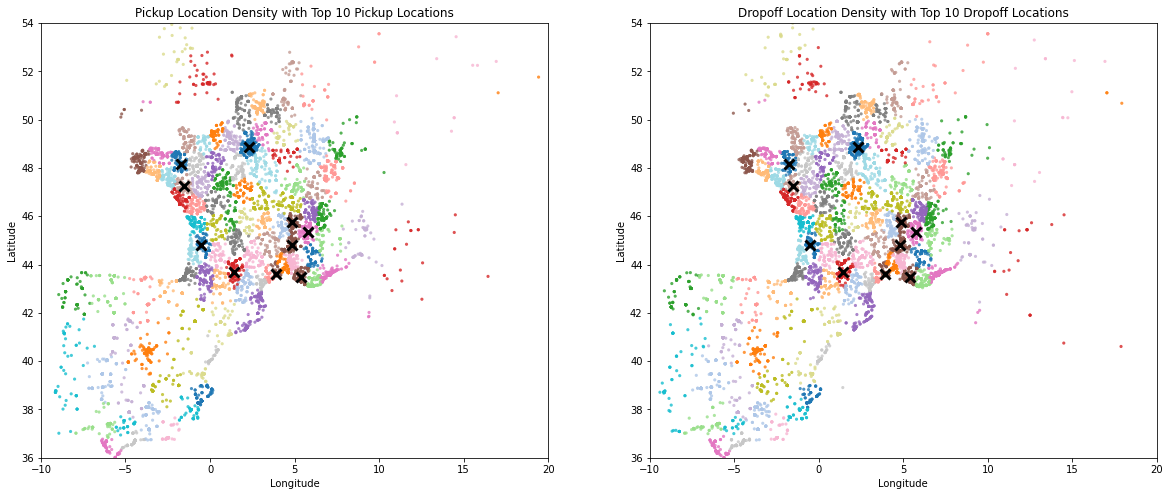

In [20]:
N = 20000

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

sample = df.sample(N)

ax[0].scatter(
    [x[1] for x in sample["from"]],
    [x[0] for x in sample["from"]],
    s=10,
    lw=0,
    c=sample["from_cluster"].values,
    cmap='tab20', alpha=0.8
)

ax[1].scatter(
    [x[1] for x in sample["to"]],
    [x[0] for x in sample["to"]],
    s=10,
    lw=0,
    c=sample["to_cluster"].values,
    cmap='tab20', alpha=0.8
)

ax[0].scatter(
    [x[1] for x in kmeans.cluster_centers_[top_to_clusters, :]],
    [x[0] for x in kmeans.cluster_centers_[top_to_clusters, :]],
    s=100,
    lw=3,
    c="black",
    cmap='tab20', alpha=1,
    marker="x"
)

ax[1].scatter(
    [x[1] for x in kmeans.cluster_centers_[top_from_clusters, :]],
    [x[0] for x in kmeans.cluster_centers_[top_from_clusters, :]],
    s=100,
    lw=3,
    c="black",
    cmap='tab20', alpha=1,
    marker="x"
)

long_border = (-10, 20)
lat_border = (36, 54)

for axe in ax:
    axe.set_xlim(long_border)
    axe.set_ylim(lat_border)
    axe.set_xlabel('Longitude')
    axe.set_ylabel('Latitude')

ax[0].title.set_text("Pickup Location Density with Top 10 Pickup Locations")
ax[1].title.set_text("Dropoff Location Density with Top 10 Dropoff Locations")

plt.show()

It seems that BlaBlaCar is mainly used in France and Spain (at least according to the provided dataset), and more popular in France than Spain. This may explain why success is more likely to happen if the driver's signup country is France. There are simply more BlaBlaCar users in France.

### Effect of pickup cluster activity

(-1.0, 10.0)

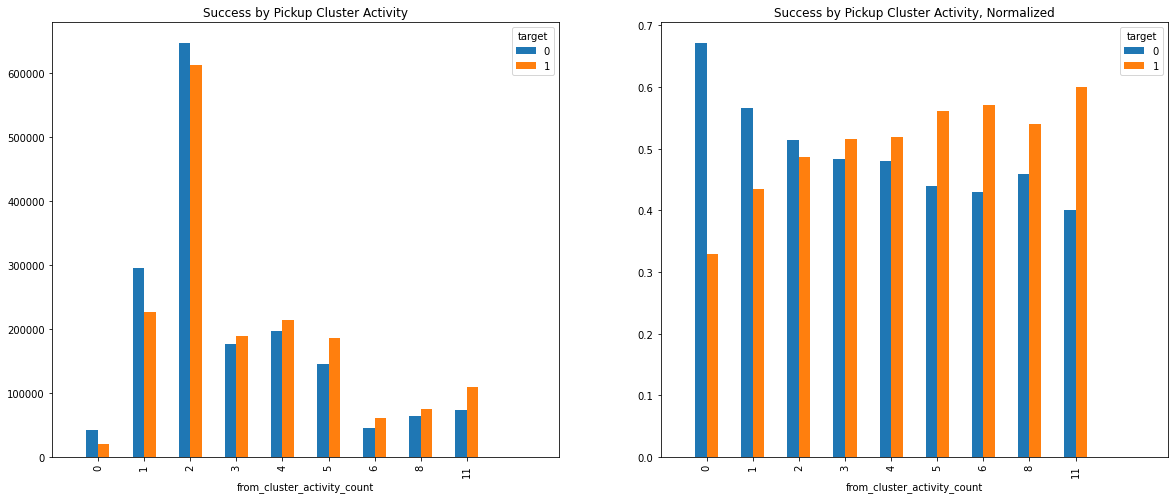

In [22]:
df_temp = df[["from_cluster_activity_count", "target", "driver_id"]].copy().dropna()
df_temp["from_cluster_activity_count"] = df["from_cluster_activity_count"].apply(lambda x: round(x * 100))

counts = df_temp.groupby(["from_cluster_activity_count", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Pickup Cluster Activity", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Pickup Cluster Activity, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 10))
ax[1].set_xlim((-1, 10))

More active pickup clusters have a higher success rate.

### Effect of dropoff cluster activity

(-1.0, 10.0)

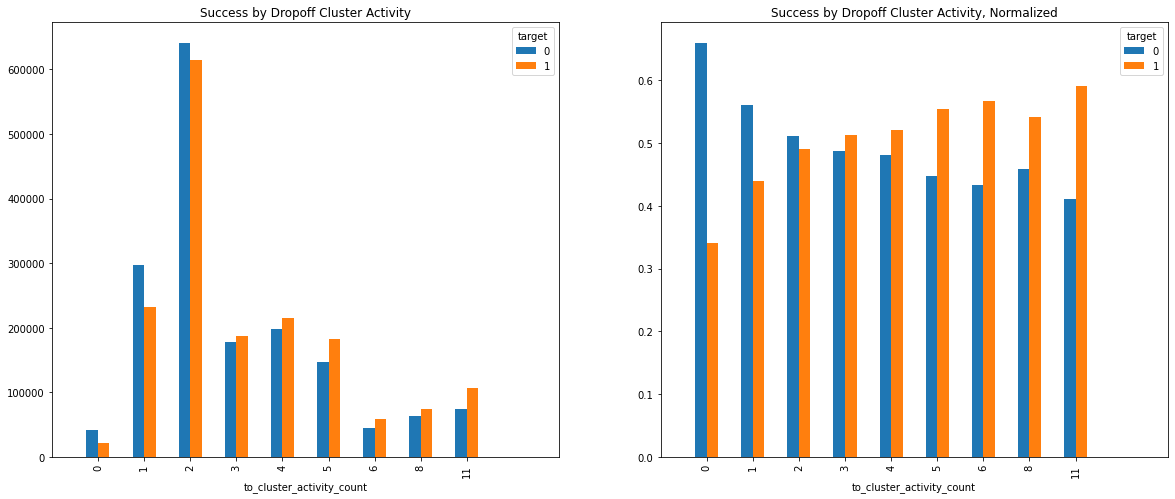

In [23]:
df_temp = df[["to_cluster_activity_count", "target", "driver_id"]].copy().dropna()
df_temp["to_cluster_activity_count"] = df["to_cluster_activity_count"].apply(lambda x: round(x * 100))

counts = df_temp.groupby(["to_cluster_activity_count", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Dropoff Cluster Activity", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Dropoff Cluster Activity, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 10))
ax[1].set_xlim((-1, 10))

More active dropoff clusters have a higher success rate.

In [21]:
def haversine_array(t1, t2):
    lat1, lng1 = [x[0] for x in t1], [x[1] for x in t1]
    lat2, lng2 = [x[0] for x in t2], [x[1] for x in t2]

    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [22]:
df["haversine_distance"] = haversine_array(df["from"], df["to"])
df["over_lenghtification"] = df["segment_distance_km"] / df["haversine_distance"]

### Effect of airplane distance (Haversine)

(-1.0, 30.0)

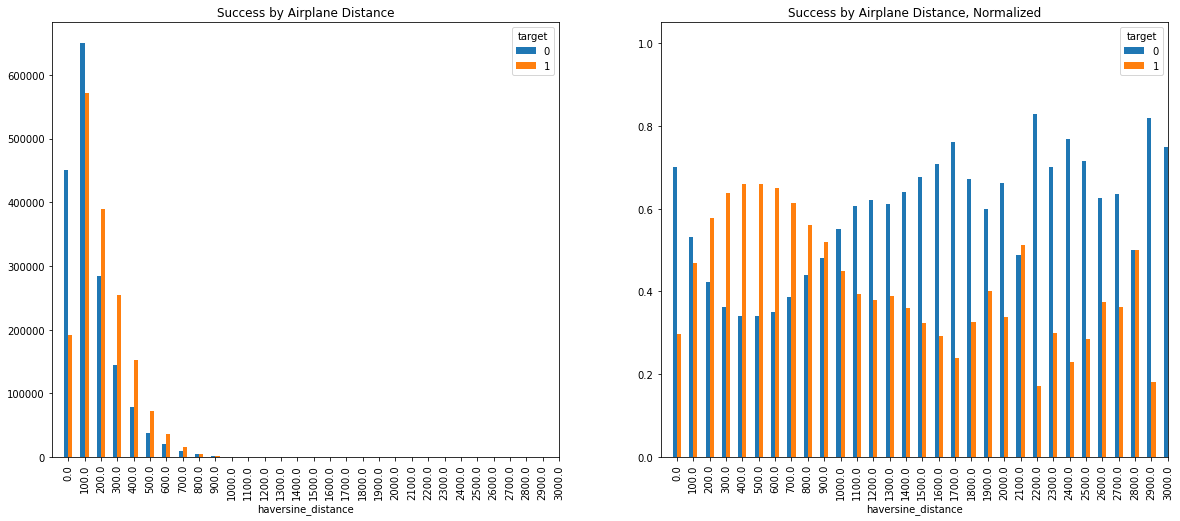

In [26]:
df_temp = df[["haversine_distance", "target", "driver_id"]].copy().dropna()
df_temp["haversine_distance"] = df["haversine_distance"].apply(lambda x: round(x, -2))

counts = df_temp.groupby(["haversine_distance", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Airplane Distance", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Airplane Distance, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 30))
ax[1].set_xlim((-1, 30))

We've seen a similar pattern in segment duration. Success rate increases with airplane distance up to a certain point (500 km), then starts decreasing. People don't want to travel very long distances in a car.

### Effect of road distance (through stopovers)

It's not clear whether the segment distance in km provided in the dataset is road distance or airplane distance in core segments. But in any case it's closer to road distance than Haversine distance because it takes stopovers into account.

(-1.0, 30.0)

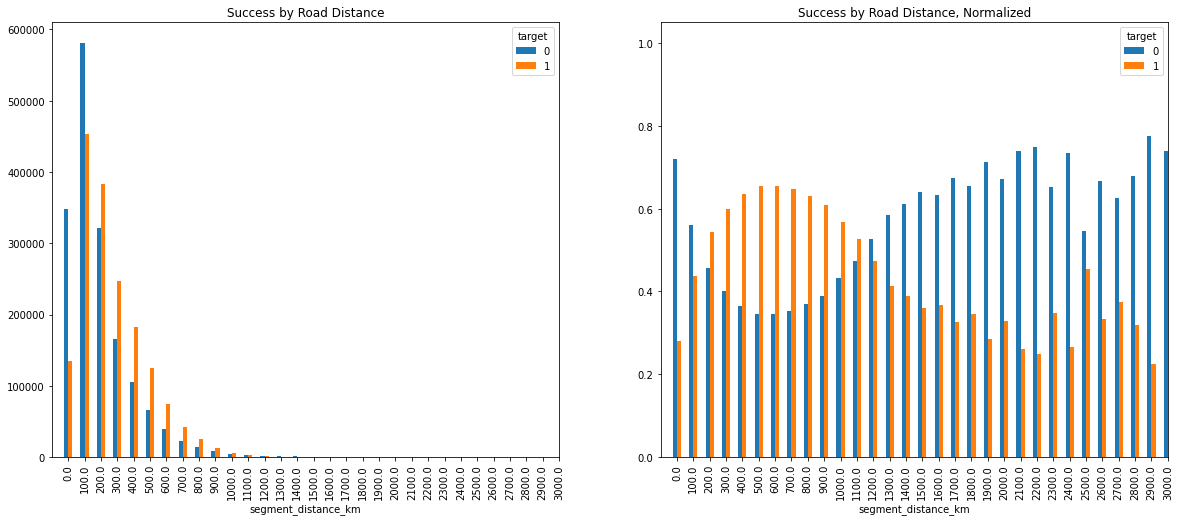

In [27]:
df_temp = df[["segment_distance_km", "target", "driver_id"]].copy().dropna()
df_temp["segment_distance_km"] = df["segment_distance_km"].apply(lambda x: round(x, -2))

counts = df_temp.groupby(["segment_distance_km", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Road Distance", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Road Distance, Normalized", ax=ax[1])

ax[0].set_xlim((-1, 30))
ax[1].set_xlim((-1, 30))

Very similar pattern.

### Effects of overlengthification

Overlengthification is a term I made up to refer to the ratio between road distance and airplane distance.

This analysis only makes sense if we study core segments and composite segments separately.

(-2.0, 50.0)

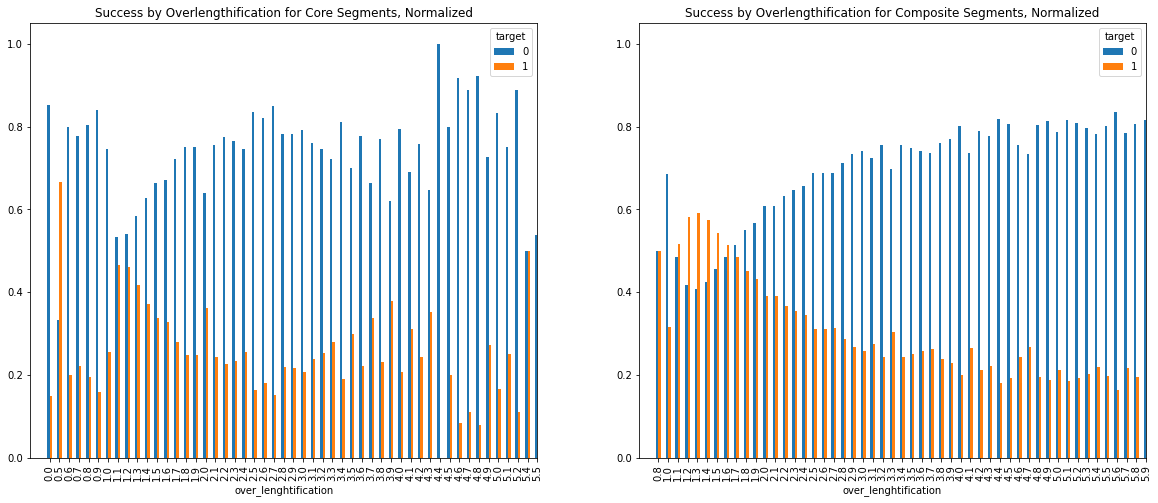

In [37]:
df_temp = df[["over_lenghtification", "target", "driver_id", "length"]].copy()
df_temp = df_temp.replace(np.inf, None).dropna()
df_temp["over_lenghtification"] = df_temp["over_lenghtification"].apply(lambda x: round(x, 1))

df_temp_core = df_temp[df_temp["length"] == 1]
df_temp_composite = df_temp[df_temp["length"] > 1]

counts_core = df_temp_core.groupby(["over_lenghtification", "target"]).count()["driver_id"]
percentages_core = counts_core / counts_core.groupby(level=0).sum()

counts_composite = df_temp_composite.groupby(["over_lenghtification", "target"]).count()["driver_id"]
percentages_composites = counts_composite / counts_composite.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

percentages_core.unstack().plot.bar(title="Success by Overlengthification for Core Segments, Normalized", ax=ax[0])
percentages_composites.unstack().plot.bar(title="Success by Overlengthification for Composite Segments, Normalized", ax=ax[1])

ax[0].set_xlim((-2, 50))
ax[1].set_xlim((-2, 50))

(-2.0, 50.0)

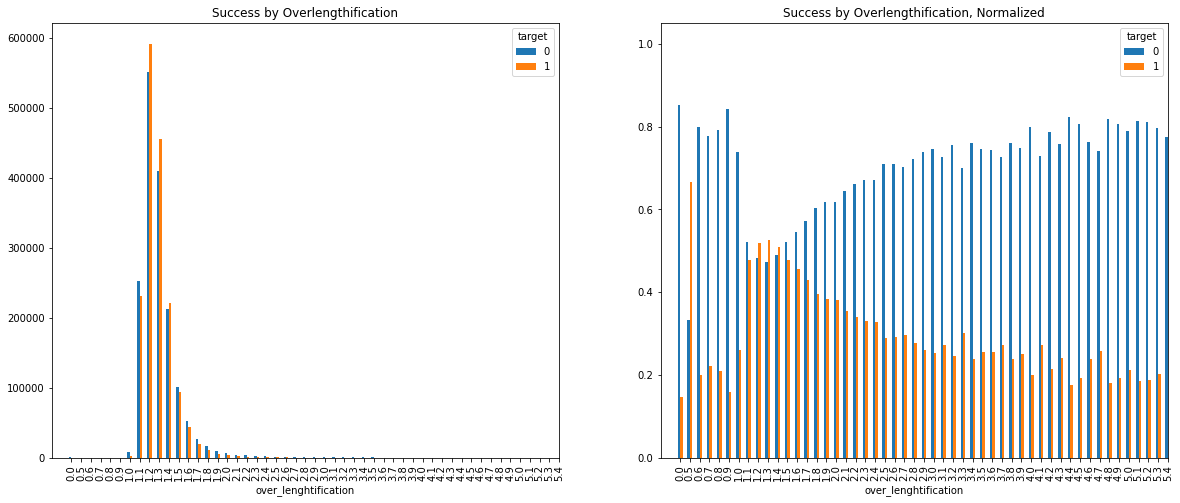

In [45]:
df_temp = df[["over_lenghtification", "target", "pickup_hour", "length"]].copy()
df_temp = df_temp.replace(np.inf, None).dropna()
df_temp["over_lenghtification"] = df_temp["over_lenghtification"].apply(lambda x: round(x, 1))

counts = df_temp.groupby(["over_lenghtification", "target"]).count()["pickup_hour"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Overlengthification", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Overlengthification, Normalized", ax=ax[1])

ax[0].set_xlim((-2, 50))
ax[1].set_xlim((-2, 50))

### Effect of price

Price on its own isn't a very useful feature, but if considered per KM of traveled distance it may be a good predictor of success.

(-2.0, 50.0)

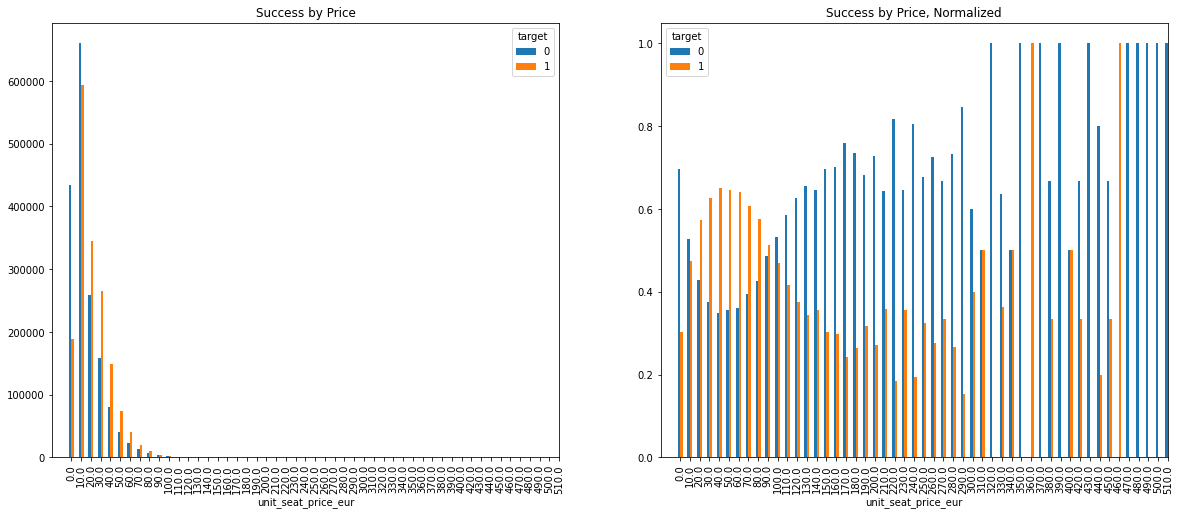

In [24]:
df_temp = df[["unit_seat_price_eur", "target", "driver_id"]].copy()
df_temp = df_temp.replace(np.inf, None).dropna()
df_temp["unit_seat_price_eur"] = df_temp["unit_seat_price_eur"].apply(lambda x: round(x, -1))

counts = df_temp.groupby(["unit_seat_price_eur", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Price", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Price, Normalized", ax=ax[1])

ax[0].set_xlim((-2, 50))
ax[1].set_xlim((-2, 50))

In [25]:
df["price_per_airplane_km"] = df["unit_seat_price_eur"] / df["haversine_distance"]
df["price_per_road_km"] = df["segment_distance_km"] / df["haversine_distance"]

(-2.0, 50.0)

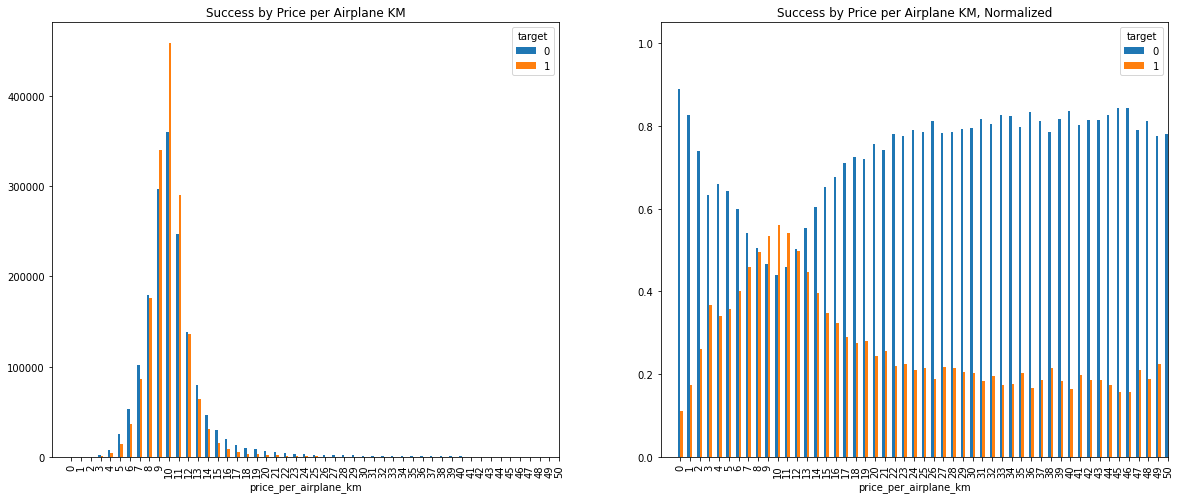

In [29]:
df_temp = df[["price_per_airplane_km", "target", "driver_id"]].copy()
df_temp = df_temp.replace(np.inf, None).dropna()
df_temp["price_per_airplane_km"] = df_temp["price_per_airplane_km"].apply(lambda x: round(x * 100))

counts = df_temp.groupby(["price_per_airplane_km", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Price per Airplane KM", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Price per Airplane KM, Normalized", ax=ax[1])

ax[0].set_xlim((-2, 50))
ax[1].set_xlim((-2, 50))

(50.0, 150.0)

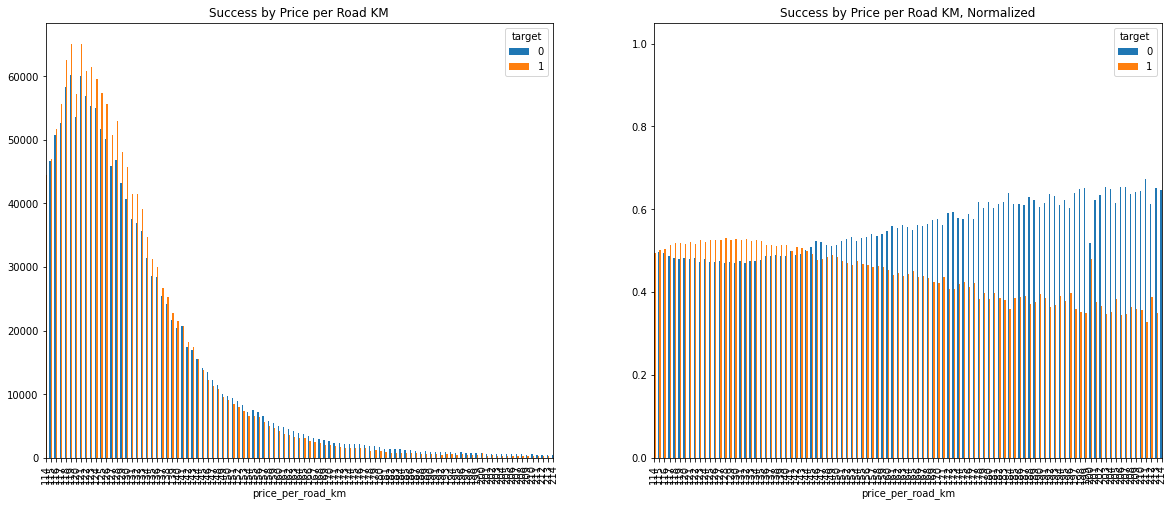

In [33]:
df_temp = df[["price_per_road_km", "target", "driver_id"]].copy()
df_temp = df_temp.replace(np.inf, None).dropna()
df_temp["price_per_road_km"] = df_temp["price_per_road_km"].apply(lambda x: round(x * 100))

counts = df_temp.groupby(["price_per_road_km", "target"]).count()["driver_id"]
percentages = counts / counts.groupby(level=0).sum()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

counts.unstack().plot.bar(title="Success by Price per Road KM", ax=ax[0])
percentages.unstack().plot.bar(title="Success by Price per Road KM, Normalized", ax=ax[1])

ax[0].set_xlim((50, 150))
ax[1].set_xlim((50, 150))

### Drop unnecessary columns

In [34]:
df.drop(["driver_id", "confirmed_seat_count", "seat_left_count"], inplace=True, axis=1)
df.drop("is_comfort", inplace=True, axis=1) # is_comfort is always False
df.drop(["segment_datetime", "published_date", "signup_date"], inplace=True, axis=1)
df.drop(["from", "to"], inplace=True, axis=1)

In [35]:
df = df.replace(np.nan, None)
df = df.replace(np.inf, None)

In [36]:
df = df[[c for c in df.columns if c != "target"] + ["target"]]

### Splitting the data into training and test sets

Split carefully: we don't want segments belonging to the same trip be in train and test

In [37]:
trip_ids = df.index.levels[0]
train_trip_ids, test_trip_ids = train_test_split(trip_ids, test_size=0.2)

train, test = df.loc[train_trip_ids], df.loc[test_trip_ids]

In [38]:
X_train, Y_train = train.loc[:, train.columns[:-1]], train.loc[:, train.columns[-1]]
X_test, Y_test = test.loc[:, train.columns[:-1]], test.loc[:, train.columns[-1]]

### Modeling

In [39]:
model = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100
)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=56,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Evaluation

In [40]:
Y_pred = model.predict(X_test)

In [41]:
print(classification_report(Y_test.astype(float), Y_pred.astype(float)))

              precision    recall  f1-score   support

         0.0       0.68      0.65      0.67    337402
         1.0       0.67      0.70      0.68    340639

    accuracy                           0.68    678041
   macro avg       0.68      0.67      0.67    678041
weighted avg       0.68      0.68      0.67    678041



### Analysis of performance metrics

The problem is a balanced classification problem. Therefore, accuracy can safely be used as a metric to measure the performance of the model.

We have an accuracy of 0.68 on a binary classification problem. This is slightly better than random guessing, which is bad. Could it be that there are factors that explain success outside this dataset (such as car model, driver rating, the number of trips they made, whether they have a profile picture, etc)? It's either that or I haven't done a very good job at feature engineering.

One factor that may be important is how many other people are proposing a trip for a given segment at around the same time. It may be that we can create features that quantify this.

### Feature Importance Analysis

<AxesSubplot:xlabel='0'>

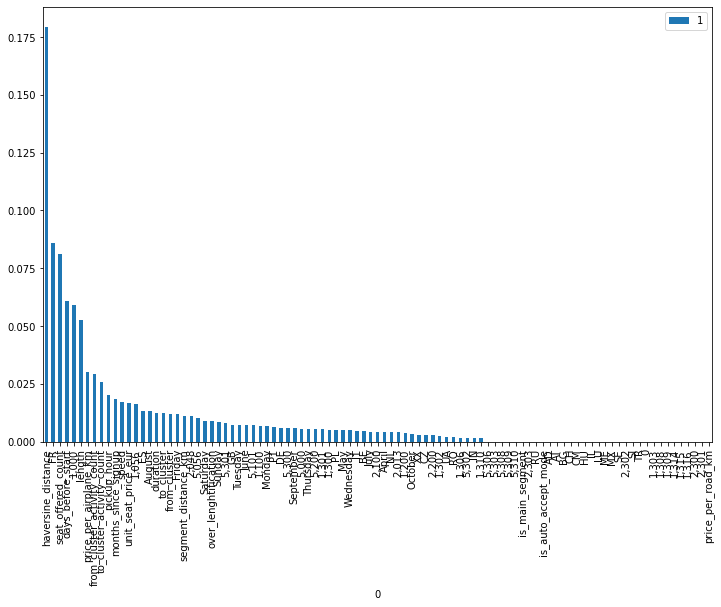

In [42]:
pd.DataFrame(zip(train.columns[:-1], model.feature_importances_)).set_index(0).sort_values(by=1, ascending=False).plot.bar(figsize=(12, 8))

In [43]:
explainer = shap.TreeExplainer(model)

shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


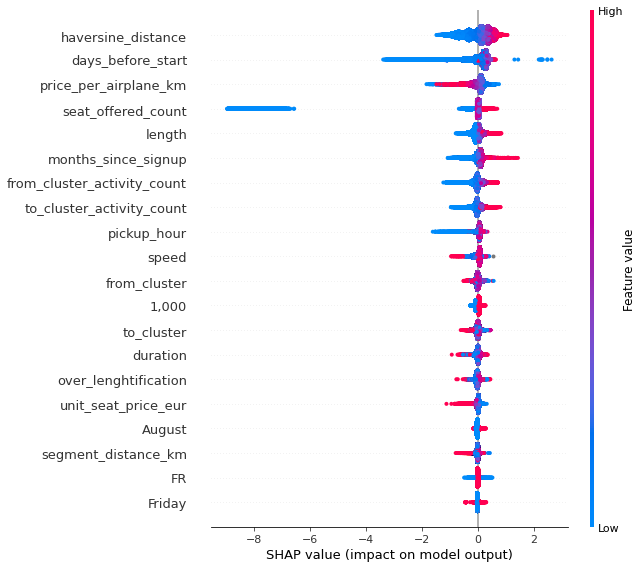

In [44]:
shap.summary_plot(shap_values, X_test)

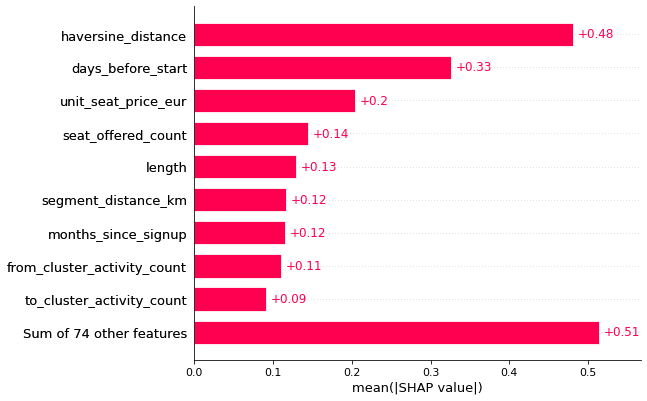

In [53]:
shap.plots.bar(shap_values)

In [54]:
Y_pred[1]

1

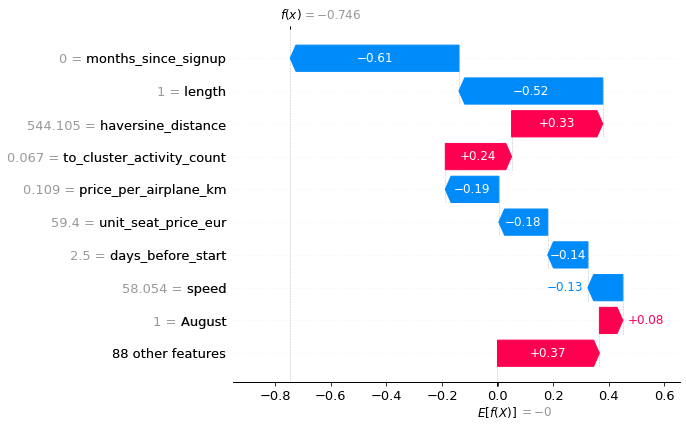

In [45]:
shap.plots.waterfall(shap_values[102])